# Exploring Dandiset 001174: Calcium Imaging in SMA and M1 of Macaques

## Overview
This Jupyter notebook provides an introduction to **[Dandiset 001174: Calcium imaging in SMA and M1 of macaques](https://dandiarchive.org/dandiset/001174/0.250331.2218)**. The dataset contains one-photon calcium imaging recordings from the supplementary motor area (SMA) and primary motor cortex (M1) of rhesus macaques performing an arm reaching task. Key features include:
- In vivo calcium imaging using GCaMP6f indicator
- Recordings from 4 rhesus macaques
- Data collected during rest and arm reaching tasks
- Neuronal coactivation patterns in motor cortices
- Data provided in NWB format

*Note: This notebook was generated with AI assistance. Please verify all code and interpretations.*

## Dandiset Metadata
First let's retrieve basic information about the dandiset using the DANDI API:

In [1]:
from dandi.dandiapi import DandiAPIClient

client = DandiAPIClient()
dandiset = client.get_dandiset("001174", "0.250331.2218")
metadata = dandiset.get_raw_metadata()

print(f"Dandiset name: {metadata['name']}")
print(f"Description: {metadata['description']}")
print(f"Species: {metadata['assetsSummary']['species'][0]['name']}")
print(f"Number of subjects: {metadata['assetsSummary']['numberOfSubjects']}")
print(f"License: {metadata['license'][0]}")
print(f"URL: {metadata['url']}")

Dandiset name: Calcium imaging in SMA and M1 of macaques
Description: The study of motor cortices in non-human primates is relevant to our understanding of human motor control, both in healthy conditions and in movement disorders. Calcium imaging and miniature microscopes allow the study of multiple genetically identified neurons with excellent spatial resolution. We used this method to examine activity patterns of projection neurons in deep layers of the supplementary motor (SMA) and primary motor areas (M1) in four rhesus macaques. We implanted gradient index lenses and expressed GCaMP6f to image calcium transients while the animals were at rest or engaged in an arm reaching task. We tracked the activity of SMA and M1 neurons across conditions, examined cell pairs for synchronous activity, and assessed whether SMA and M1 neuronal activation followed specific sequential activation patterns. We demonstrate the value of in vivo calcium imaging for studying patterns of activity in groups

## Exploring NWB Files
Now let's examine the NWB files in the dandiset. We'll list available assets and then inspect one file:

In [2]:
# List all assets in the dandiset
assets = list(dandiset.get_assets())
print(f"Total assets: {len(assets)}")

# Print first few NWB files
print("\nSample files:")
for asset in assets[:3]:
    if asset.path.endswith('.nwb'):
        print(f"- {asset.path}")

Total assets: 45

Sample files:
- sub-V/sub-V_ses-20230309T110929_ophys.nwb
- sub-Q/sub-Q_ophys.nwb
- sub-Q/sub-Q_ses-20220922T131747_ophys.nwb


## Streaming NWB Data
We'll now stream a sample file directly from DANDI without downloading it. We'll examine:
1. Raw calcium imaging data
2. Processed fluorescence traces
3. Neuronal spatial footprints

In [3]:
import remfile
import h5py
import pynwb
import numpy as np
import matplotlib.pyplot as plt

# Select a sample file and mount it for streaming
asset = dandiset.get_asset_by_path('sub-V/sub-V_ses-20230309T110929_ophys.nwb')
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, mode='r')
nwbfile = io.read()

print(f"\nFile ID: {nwbfile.identifier}")
print(f"Session start: {nwbfile.session_start_time}")
print(f"Acquisition keys: {list(nwbfile.acquisition.keys())}")
print(f"Processing modules: {list(nwbfile.processing.keys())}")


File ID: ef45b76c-6097-4571-bfef-7f9cc2e9c3bb
Session start: 2023-03-09 11:09:29.585000+00:00
Acquisition keys: ['OnePhotonSeries']
Processing modules: ['ophys']


## Visualizing Raw Calcium Imaging Data
Extract a single frame from the calcium imaging video:

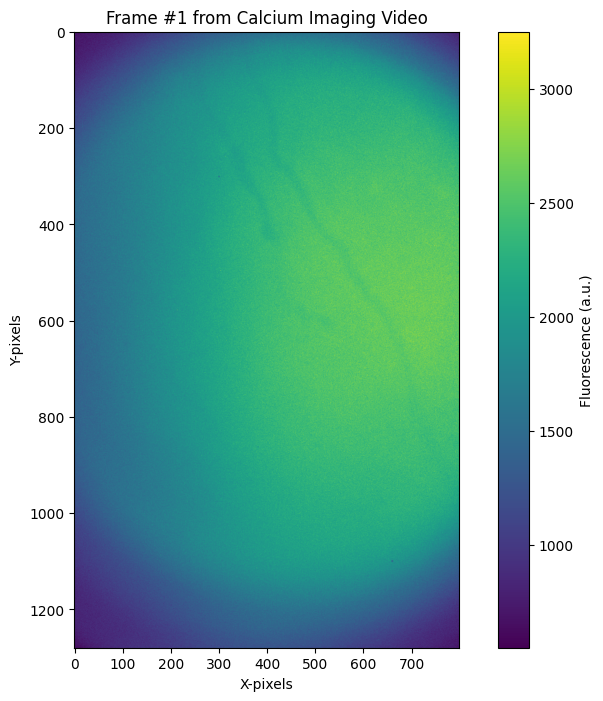

In [4]:
# Access raw imaging data
one_photon_series = nwbfile.acquisition['OnePhotonSeries']
frame_data = one_photon_series.data[0]  # First frame

# Plot the frame
plt.figure(figsize=(10, 8))
plt.imshow(frame_data, cmap='viridis')
plt.colorbar(label='Fluorescence (a.u.)')
plt.title('Frame #1 from Calcium Imaging Video')
plt.xlabel('X-pixels')
plt.ylabel('Y-pixels')
plt.show()

## Plotting Fluorescence Traces
Visualize calcium traces for example neurons:

Recording contains 5185 frames and 11 neurons


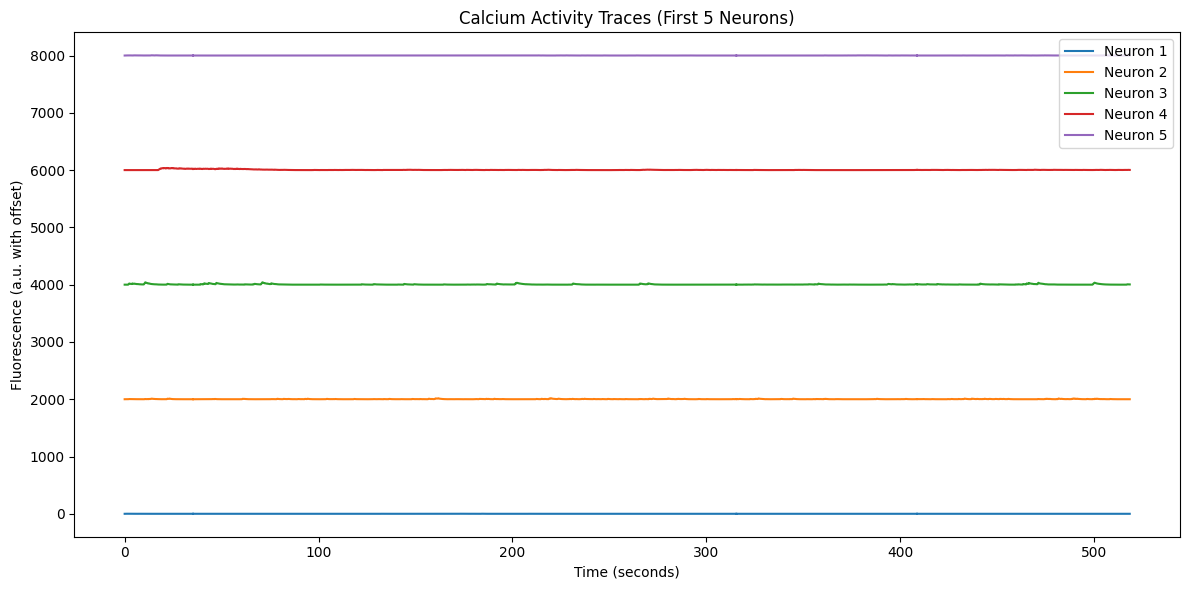

In [5]:
# Access processed fluorescence data
processing_module = nwbfile.processing['ophys']
fluorescence = processing_module.data_interfaces['Fluorescence']
roi_response = fluorescence.roi_response_series['RoiResponseSeries']

# Get data dimensions
n_frames, n_neurons = roi_response.data.shape
print(f"Recording contains {n_frames} frames and {n_neurons} neurons")

# Extract traces for first 5 neurons
traces = roi_response.data[:, :5].astype(np.float64)  # First 5 neurons

# Generate time axis (convert to seconds)
frame_rate = roi_response.rate
timestamps = np.arange(n_frames) / frame_rate

# Plot traces
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(timestamps, traces[:, i] + i * 2000,  # Add offset for visibility
             label=f'Neuron {i+1}')
    
plt.title('Calcium Activity Traces (First 5 Neurons)')
plt.ylabel('Fluorescence (a.u. with offset)')
plt.xlabel('Time (seconds)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Visualizing Spatial Footprints
Display the spatial masks for identified neurons:

Skipping mask with unexpected shape (318, 197)
Skipping mask with unexpected shape (318, 197)
Skipping mask with unexpected shape (318, 197)
Skipping mask with unexpected shape (318, 197)
Skipping mask with unexpected shape (318, 197)
Skipping mask with unexpected shape (318, 197)
Skipping mask with unexpected shape (318, 197)
Skipping mask with unexpected shape (318, 197)
Skipping mask with unexpected shape (318, 197)
Skipping mask with unexpected shape (318, 197)
Skipping mask with unexpected shape (318, 197)


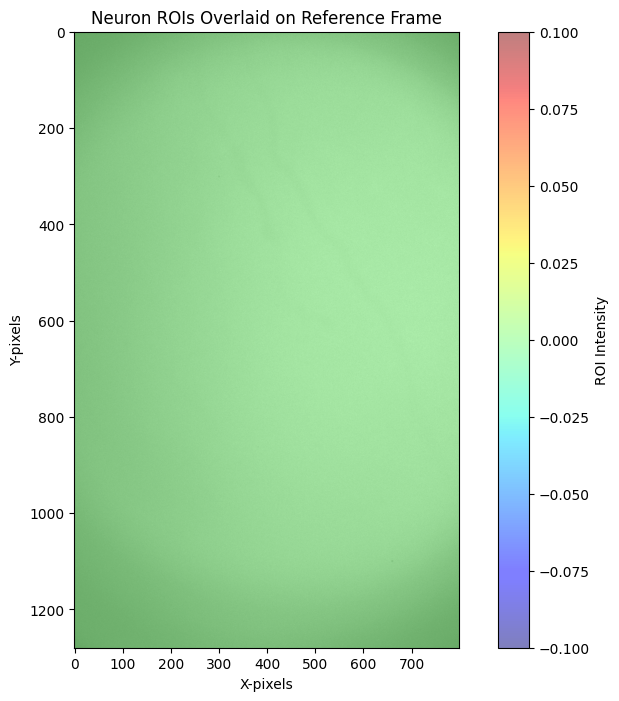

In [6]:
# Access ROI masks
segmentation = processing_module.data_interfaces['ImageSegmentation']
plane_seg = segmentation.plane_segmentations['PlaneSegmentation']
roi_masks = plane_seg['image_mask'].data[:]  # All ROI masks

# Create composite image showing all ROIs
composite_mask = np.zeros(frame_data.shape, dtype=float)
for mask in roi_masks:
    # Ensure mask is properly shaped and scaled
    if mask.shape == frame_data.shape:
        composite_mask += mask
    else:
        print(f"Skipping mask with unexpected shape {mask.shape}")

# Plot overlay
plt.figure(figsize=(10, 8))
plt.imshow(frame_data, cmap='gray', alpha=0.7)
plt.imshow(composite_mask, cmap='jet', alpha=0.5, vmin=0, vmax=composite_mask.max())
plt.title('Neuron ROIs Overlaid on Reference Frame')
plt.xlabel('X-pixels')
plt.ylabel('Y-pixels')
plt.colorbar(label='ROI Intensity')
plt.show()

## Key Takeaways
This notebook demonstrated how to:
- Access Dandiset 001174 metadata via the DANDI API
- Stream and explore NWB files directly from DANDI
- Visualize calcium imaging frames, neuronal traces, and spatial footprints

All data remain on remote servers during analysis. For deeper investigation:
- Analyze temporal correlations between neurons
- Examine event-based dynamics
- Compare activity across task conditions

Remember to close the IO connection when done:  
`io.close()`